# Choosing culture media using Bayesian optimisation

In [1]:
import pandas as pd
import torch
from botorch.test_functions.synthetic import Hartmann
from botorch.utils.sampling import draw_sobol_samples
from matplotlib import pyplot as plt
from tqdm import tqdm
import numpy as np

from src.mediabo.optimisation import get_next_batch_of_designs

/Users/tedgro/repos/ljm176/BayesianMediaOpt/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


This notebook demonstrates how to choose fermentation media using Bayesian optimisation.

## Motivation

Imagine the following situation. There we have to choose a combination of 6 medium components, say FeSO4, K2HPO4, NH4Cl, CaCl2, NaCl and Na2SO4.

Each componment can be put into a tube with a concentration between 0 and 1 arbitrary units. There are no interacting constraints, so the design space is the 6-dimensional [0, 1] hypercube.

To choose a good mixture, we can run fermentation experiments in batches of 12. Once each experiment is done, we measure the growth, yield etc and come up with a KPI that quantifies how good the mixture was.

Unfortunately, our design space is rather large: a grid search with 20 points on each dimension would require 20^6 = 64000000 experiments. That sounds like a lot of work!

## Bayesian optimisation

Fortunately we can avoid doing so many experiments by searching in a smart way and making some assumptions. 

Bayesian optimisation is a nice framework for doing this.

Bayesian optimisation combines two main components: a **surrogate model** that contains some assumptions about the relationship bewtween our designs and the KPI, and an **acquisition function** that formalises how to use experimental information to make decisions.

Bayesian optimisation is Bayesian because it uses surrogate models and acquisition functions that come with probabilities attached. For example, a Bayesian surrogate model might say that the probabilities of designs A and B scoring above 2.3 are 50% and 20% respectively. A Bayesian acquisition function might say to choose the available design with the highest probability of such a score (so design A it is!).

There is a rich and growing literature that explores various surrogate models and acquisition functions and ways of using them: to get started just try searching "Bayesian Optimisation". There is also a good amount of software implementing Bayesian optimisation, as it has lots of applications that are interesting to software companies.

In particular, the company Meta developed an open-source library called [botorch](https://botorch.org/) which we will use here.

## Gaussian Process Regression: a popular surrogate model

Since we were initially considering doing a grid search over all possible design choices, it's clear that we aren't that sure about which design is the best. We probably also think that our design choices don't affect our KPI linearly: most likely there is a sweet spot somewhere in design space that is just right, and it may well be surrounded in all directions by worse zones.

These considerations mean that we want a surrogate model that doesn't include any assumptions about which design is best, and which doesn't assume that the relationship between designs and KPIs is linear, monotonic or even that it has a particular parametric form.

Gaussian process regression allows us to avoid making these assumptions while still allowing us to extract some information from whatever experimental results we have available.

A Gaussian process is a real-valued function such that any possible set of n realisations is related by an n-dimensional multivariate Gaussian distribution. Using Gaussian process regression (and some assumptions about exactly what kind of multivariate Gaussian distribution we are dealing with) we can make inferences about which Gaussian processes best agree with a given set of data points. Gaussian process regression is a great choice for non-parametric regression problems just like ours. In fact, Gaussian process regression is the de facto default choice of surrogate model in most Bayesian optimisation settings.

 ## Framing our problem as Bayesian optimisation
 
 Our medium optimisation problem is a pretty textbook case of Bayesian optimisation, but there are a couple of interesting non-standard details.
 
 First, our design space is bounded, as there is a maximum and minimum value for each medium component.
 
 Second, we can't do sequential experiments, but instead have to carry out experiments in batches. Our decision problem therefore isn't to choose the best experiment to do next, but rather to choose the best batch of experiments.
 
 Luckily, botorch accommodates both of these peculiarities.
 
 As a surrogate model we can use botorch's default SingleTaskGP Gaussian process regression model. The details of this model are spelled out [here](https://github.com/pytorch/botorch/discussions/2451). Essentially it assumes that nearby obervations are likely to be close to each other (i.e. our Gaussian process is locally smooth), with the extent of the smoothness controlled by a parameterised [Radial Basis Function kernel](https://en.wikipedia.org/wiki/Radial_basis_function_kernel). The model uses hyperparameters chosen to target design spaces in the unit cube, just like ours.
 
 As an acquisition function, we can use botorch's [qLogExpectedImprovement](https://botorch.org/api/_modules/botorch/acquisition/logei.html#qLogExpectedImprovement). This function considers all possible batches of designs and the fitted surrogate model, estimating the probability of each batch including an improvement over the previous best design, and the likely extent of any improvements. It chooses a batch with maximal expected log-scale improvement. This acquisition function requires monte carlo sampling and is therefore a little costly.
 

## Python implementation

I wrote a function called `get_next_batch_of_designs` that does what we need.

Here it is

In [2]:
get_next_batch_of_designs??

Signature:
get_next_batch_of_designs(
    x: torch.Tensor,
    y: torch.Tensor,
    bounds: torch.Tensor | list[list[float]],
    q: int,
    seed: int | None = None,
) -> tuple[torch.Tensor, float]
Source:   
def get_next_batch_of_designs(
    x: torch.Tensor,
    y: torch.Tensor,
    bounds: torch.Tensor | list[list[float]],
    q: int,
    seed: int | None = None,
) -> tuple[torch.Tensor, float]:
    """Get a batch of new designs that optimises log expected improvement.

    This is assuming a SingleTaskGP as surrogate model.

    :param x: Tensor with shape N x d, where N is the number of training observations and d is the dimensionality of the design space. For example, if 2 designs have been tested and each design has 6 dimensions, then x has shape 2 x 6.

    :param y: Tensor with shape N x 1. The values represent measured kpi values.

    :param bounds: Tensor or list with shape 2 x d. The values represent the minimum and maximum of each design dimension.

    :q: size of the b

## Hardcoding

This cell has some hard coded variables that are used to set up the problem or for reference.

In [3]:
# labels
MEDIA = [
    "FeSO4",
    "K2HPO4",
    "NH4Cl",
    "CaCl2",
    "NaCl",
    "Na2SO4",
]

# boundaries
BOUNDS = [[0.0] * len(MEDIA), [1.0] * len(MEDIA)]

# shapes
Q = 12
D = len(MEDIA)

# see https://botorch.org/api/_modules/botorch/test_functions/synthetic.html#Hartmann
TRUE_ARGOPTIMUM = (0.20169, 0.150011, 0.476874, 0.275332, 0.311652, 0.6573)
TRUE_OPTIMUM = 3.32237

# Fix random seed
SEED = 12345
torch.manual_seed(seed=SEED)

## Simulation experiment

To illustrate how to use this function and test whether it actually works we can use a known target function to generate a dataset and try to find its true optimum.

The [Hartmann function](https://www.sfu.ca/~ssurjano/hart6.html) is a good choice. It has the right dimensionality and boundaries, and is suitably tricky, with 6 local optima that could potentially trap a bad algorithm.

The next cell instantiates this function and shows its true values when component 2 is varied across the possible range from zero to one, holding all other components constant at 0.1. 

[Text(0.5, 0, 'mixture[2]'), Text(0, 0.5, 'KPI')]

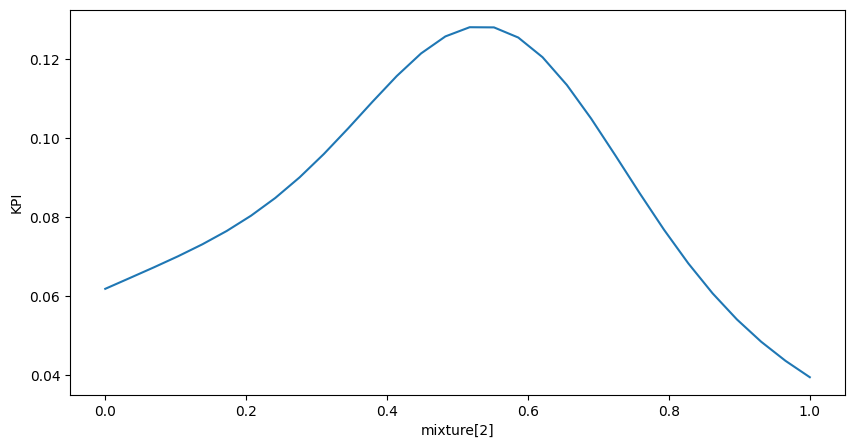

In [4]:
tuple_bounds = [(a, b) for a, b in list(zip(BOUNDS[0], BOUNDS[1]))]
truth = Hartmann(dim=D, bounds=tuple_bounds, negate=True, noise_std=0.05)

x = np.linspace(0, 1, 30)
kpis = []
for xi in x:
    mixture = torch.Tensor([0.1] * 6)
    mixture[2] = xi
    kpis.append(truth.forward(mixture, noise=False))
    
f, ax = plt.subplots(figsize=[10, 5])
ax.plot(x, kpis)
ax.set(xlabel="mixture[2]", ylabel="KPI")

To start with we need to choose a first set of experiments.

For this we use Sobol sampling to choose a set of more or less evenly spaced designs from across the search space.

In [5]:
bounds_t = torch.Tensor(BOUNDS)
first_x = draw_sobol_samples(
    bounds=bounds_t,
    q=Q,
    n=1,
    seed=SEED,
).squeeze(0)
first_x

tensor([[0.5903, 0.4354, 0.5665, 0.7906, 0.9171, 0.8489],
        [0.6098, 0.5111, 0.3035, 0.9932, 0.9701, 0.0539],
        [0.8316, 0.4975, 0.8129, 0.6785, 0.0591, 0.5980],
        [0.6027, 0.7184, 0.7107, 0.5071, 0.3685, 0.3253],
        [0.1681, 0.3371, 0.6321, 0.5505, 0.4481, 0.8452],
        [0.0032, 0.5110, 0.1705, 0.2361, 0.8953, 0.2370],
        [0.9211, 0.2836, 0.4373, 0.7805, 0.7267, 0.3063],
        [0.7410, 0.6607, 0.0122, 0.8449, 0.3540, 0.0141],
        [0.2956, 0.9570, 0.9429, 0.1592, 0.3147, 0.8867],
        [0.7367, 0.4789, 0.5669, 0.2285, 0.7859, 0.3768],
        [0.0929, 0.2781, 0.1957, 0.1672, 0.0349, 0.6260],
        [0.9392, 0.3833, 0.5661, 0.6740, 0.2096, 0.4533]])

In [6]:
truth.forward?

Signature: truth.forward(X: 'Tensor', noise: 'bool' = True) -> 'Tensor'
Docstring:
Evaluate the function on a set of points.

Args:
    X: A `(batch_shape) x d`-dim tensor of point(s) at which to evaluate
        the function.
    noise: If `True`, add observation noise as specified by `noise_std`.

Returns:
    A `batch_shape`-dim tensor ouf function evaluations.
File:      ~/repos/ljm176/BayesianMediaOpt/.venv/lib/python3.12/site-packages/botorch/test_functions/base.py
Type:      method

Now we can run the main loop

In [7]:
rounds = 2
x = first_x
y = torch.Tensor([])
best = []
pbar = tqdm(range(rounds))
next_x = first_x

for r in pbar:
    
    next_y = truth.forward(next_x, noise=True).unsqueeze(-1)
    y = torch.concat([y, next_y])
    print(y.shape)
    next_x, lei = get_next_batch_of_designs(
        x=x,
        y=y,
        bounds=BOUNDS,
        q=Q,
        seed=SEED,
    )

    best_so_far = float(y.max())
    msg = f"Best after round {r}: " + str(best_so_far)
    pbar.set_description(msg)
    best.append([r, best_so_far])
    x = torch.concat([x, next_x])
x

  0%|                                                               | 0/2 [00:00<?, ?it/s]

torch.Size([12, 1])


Best after round 0: 0.9412739014575974:  50%|███████▌       | 1/2 [00:01<00:01,  1.03s/it]

torch.Size([24, 1])


Best after round 1: 1.3201683819979364: 100%|███████████████| 2/2 [00:01<00:00,  1.22it/s]


tensor([[5.9030e-01, 4.3545e-01, 5.6645e-01, 7.9057e-01, 9.1715e-01, 8.4893e-01],
        [6.0983e-01, 5.1112e-01, 3.0345e-01, 9.9323e-01, 9.7008e-01, 5.3929e-02],
        [8.3163e-01, 4.9751e-01, 8.1286e-01, 6.7851e-01, 5.9145e-02, 5.9800e-01],
        [6.0266e-01, 7.1835e-01, 7.1067e-01, 5.0712e-01, 3.6850e-01, 3.2526e-01],
        [1.6809e-01, 3.3709e-01, 6.3206e-01, 5.5046e-01, 4.4806e-01, 8.4521e-01],
        [3.2100e-03, 5.1101e-01, 1.7051e-01, 2.3614e-01, 8.9526e-01, 2.3698e-01],
        [9.2113e-01, 2.8365e-01, 4.3730e-01, 7.8053e-01, 7.2671e-01, 3.0631e-01],
        [7.4104e-01, 6.6066e-01, 1.2165e-02, 8.4489e-01, 3.5401e-01, 1.4141e-02],
        [2.9562e-01, 9.5699e-01, 9.4287e-01, 1.5922e-01, 3.1469e-01, 8.8669e-01],
        [7.3671e-01, 4.7894e-01, 5.6686e-01, 2.2850e-01, 7.8591e-01, 3.7679e-01],
        [9.2947e-02, 2.7814e-01, 1.9567e-01, 1.6723e-01, 3.4878e-02, 6.2603e-01],
        [9.3919e-01, 3.8326e-01, 5.6611e-01, 6.7403e-01, 2.0959e-01, 4.5326e-01],
        [7.1684e

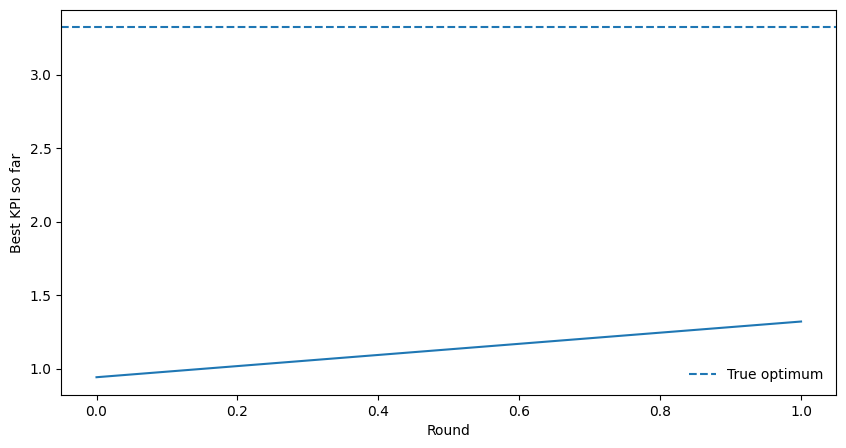

In [8]:
best = pd.DataFrame(best, columns=["round", "best"])
f, ax = plt.subplots(figsize=[10, 5])
ax.plot(best["round"], best["best"])
ax.set(xlabel="Round", ylabel="Best KPI so far")
ax.axhline(TRUE_OPTIMUM, linestyle="--", label="True optimum")
ax.legend(frameon=False)

In [9]:
y.shape

torch.Size([24, 1])